Steane code decoding with noise
===========================

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up the ancilla

3. The error correction circuit is not set up because it introduces to much noise.

4. Set up the decoding circuit and measure the error.

The program runs through different scenarios to assess the noise introduced by the encoding, detection and decoding separately.

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_noise)

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

DATA_QUBITS = 7
ANCILLA_QUBITS = 3

MCT = True      #Use Multi Control Toffoli (MCT) gates
FAIL_X = True   #Enduce a Pauli X failure in one bit
FAIL_Z = True   #Enduce a Pauli Z failure in one bit

ERROR_REDUCTION = 1

NOISE = True                                              #Test with noise
SHOTS = 10000                                             #Number of shots to run    
MEASURE_NOISE = 0.0046 * ERROR_REDUCTION                  #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366 * ERROR_REDUCTION     #Single gate noise   
#TWO_GATE_DEPOLARISING = 0.0102 * ERROR_REDUCTION         #Two gate noise
TWO_GATE_DEPOLARISING = 0.0204 * ERROR_REDUCTION 
#  note change to agree results - may need to change back

SIMULATOR = Aer.get_backend('qasm_simulator')

Specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = [[0,0,0,1,1,1,1],
                       [0,1,1,0,0,1,1],
                       [1,0,1,0,1,0,1]]

The allowed codewords for the zero logical from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = [[0,0,0,0,0,0,0],   
             [1,0,1,0,1,0,1],
             [0,1,1,0,0,1,1],
             [1,1,0,0,1,1,0],
             [0,0,0,1,1,1,1],
             [1,0,1,1,0,1,0],
             [0,1,1,1,1,0,0],
             [1,1,0,1,0,0,1]]

Error decoding
---------------------

Different scenarios are set up to measure the noise of each component.

The initial bit string is '0000000'.  After encoding the valid bit strings are as shown in the codewords list above.  Finally, after decoding, the valid bit string is again '0000000'.

In [6]:
#graph indices
labels = []
last_stage_error = []
this_stage_error = []
#set up scenarios ready to loop through
scenarios = {
        'measurement only':{
            'Encoding' : False, 'Ancilla' : False, 'Decoding' : False, 'Use_Initial_codeword' : True
               },
        'encoding':{
            'Encoding' : True, 'Ancilla' : False, 'Decoding' : False, 'Use_Initial_codeword' : False
               },
        'detection':{
            'Encoding' : True, 'Ancilla' : True, 'Decoding' : False, 'Use_Initial_codeword' : False
                },
        'decoding':{
            'Encoding' : True, 'Ancilla' : True, 'Decoding' : True, 'Use_Initial_codeword' : True
                }
            }

initial_codeword = [[0,0,0,0,0,0,0]]
last_error_rate = 0
last_count_invalid = 0
# used after decoding
print(f'An error reduction factor of {ERROR_REDUCTION:.4f} is used.')
print()

for cases, parameters in scenarios.items():
    encoding = parameters.get('Encoding')
    ancilla = parameters.get('Ancilla')
    decoding = parameters.get('Decoding')
    use_initial_codeword = parameters.get('Use_Initial_codeword')
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, extend_ancilla = False)
    if encoding:
        qubit.set_up_logical_zero()
        qubit.barrier()
    if ancilla:
        qubit.set_up_ancilla()
        qubit.barrier()
    if decoding:
        qubit.decode()

    if NOISE:
        noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, 
                                TWO_GATE_DEPOLARISING, SINGLE_GATE_SET, TWO_GATE_SET)
    qubit.logical_measure()
    qubit.barrier()
    #Measurement noise

    qt = transpile(qubit, basis_gates = BASIS_GATE_SET)
    if NOISE:
        result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qt, SIMULATOR, shots = SHOTS).result()

    counts = result.get_counts(qt)
    print(f'For the scenario with {cases} the results are:' )
    labels.append(cases)
    #print ('The different states can be counted.  The simulated result are', counts)
    if use_initial_codeword:
        valid_codewords = initial_codeword
    else:
        valid_codewords = codewords
    count_valid, count_invalid = count_valid_output_strings(counts, valid_codewords, 2)
    #print(f'Valid codewords {valid_codewords}')      
    error_rate = count_invalid / SHOTS
    print(f'The cumulative error rate is {error_rate:.4f}')
    
    print(f'There were {count_invalid} invalid bit strings after this stage and {count_valid} valid bit strings')
    if last_count_invalid > 0:
        stage_count_invalid = count_invalid - last_count_invalid
        print(f'This stage introduced {stage_count_invalid} new errors')
        
    stage_error_rate = (error_rate - last_error_rate)
    print(f'The error rate introduced by this stage is {stage_error_rate:.4f}')
    print(f'The prior error rate is {last_error_rate:.4f}')

    this_stage_error.append(error_rate)
    last_stage_error.append(last_error_rate)
    
    last_error_rate = error_rate
    last_count_invalid = count_invalid
    print()

An error reduction factor of 1.0000 is used.

For the scenario with measurement only the results are:
The cumulative error rate is 0.0339
There were 339 invalid bit strings after this stage and 9661 valid bit strings
The error rate introduced by this stage is 0.0339
The prior error rate is 0.0000

For the scenario with encoding the results are:
The cumulative error rate is 0.1915
There were 1915 invalid bit strings after this stage and 8085 valid bit strings
This stage introduced 1576 new errors
The error rate introduced by this stage is 0.1576
The prior error rate is 0.0339

For the scenario with detection the results are:
The cumulative error rate is 0.4154
There were 4154 invalid bit strings after this stage and 5846 valid bit strings
This stage introduced 2239 new errors
The error rate introduced by this stage is 0.2239
The prior error rate is 0.1915

For the scenario with decoding the results are:
The cumulative error rate is 0.6685
There were 6685 invalid bit strings after this s

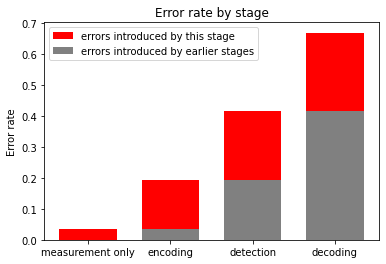

In [7]:
import matplotlib.pyplot as plt
YMIN = 0
YMAX = 1.0
YTICK = 0.2
WIDTH = 0.7

fig, ax = plt.subplots()

ax.bar(labels, this_stage_error, WIDTH, label = 'errors introduced by this stage', color = "red")
ax.bar(labels, last_stage_error, WIDTH, label = 'errors introduced by earlier stages', color = "grey")

ax.set_ylabel('Error rate')
ax.set_title('Error rate by stage')
ax.legend()

#plt.show()

fname = "Steane code errors in each stage"
plt.savefig(fname)

Draw circuit

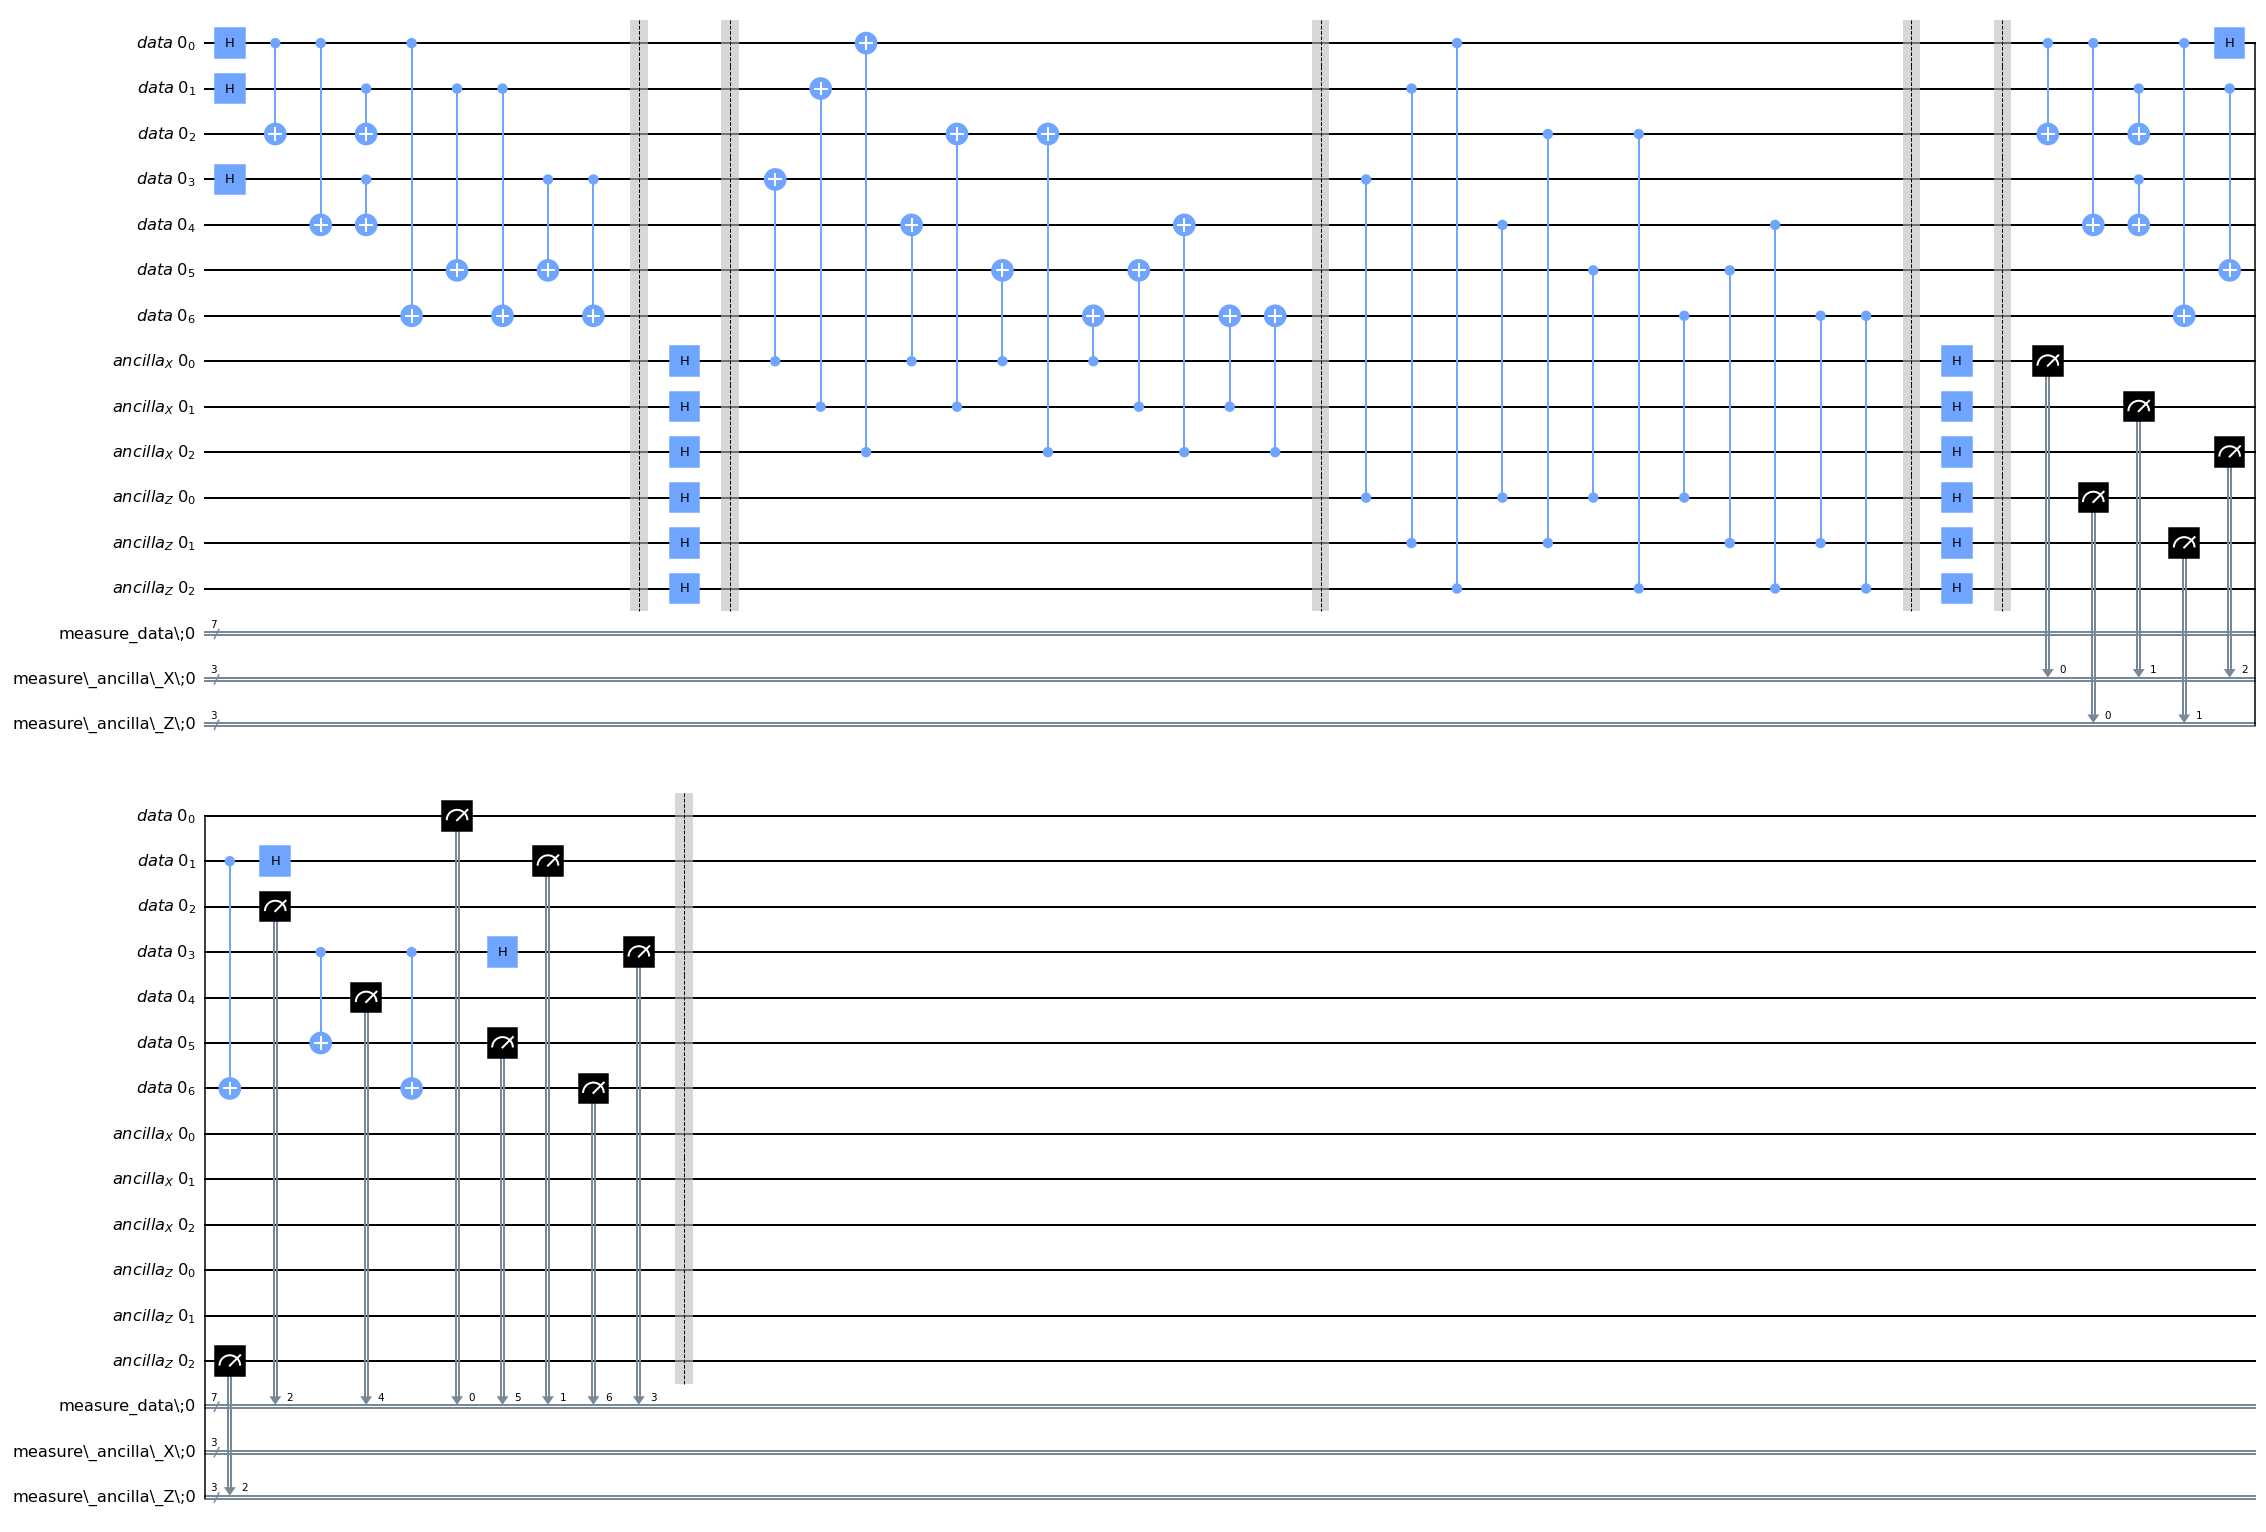

In [8]:
qubit.draw(output = 'mpl', filename = 'Steane_code_decoding_circuit.jpg', fold = 45)

Draw transpiled circuit

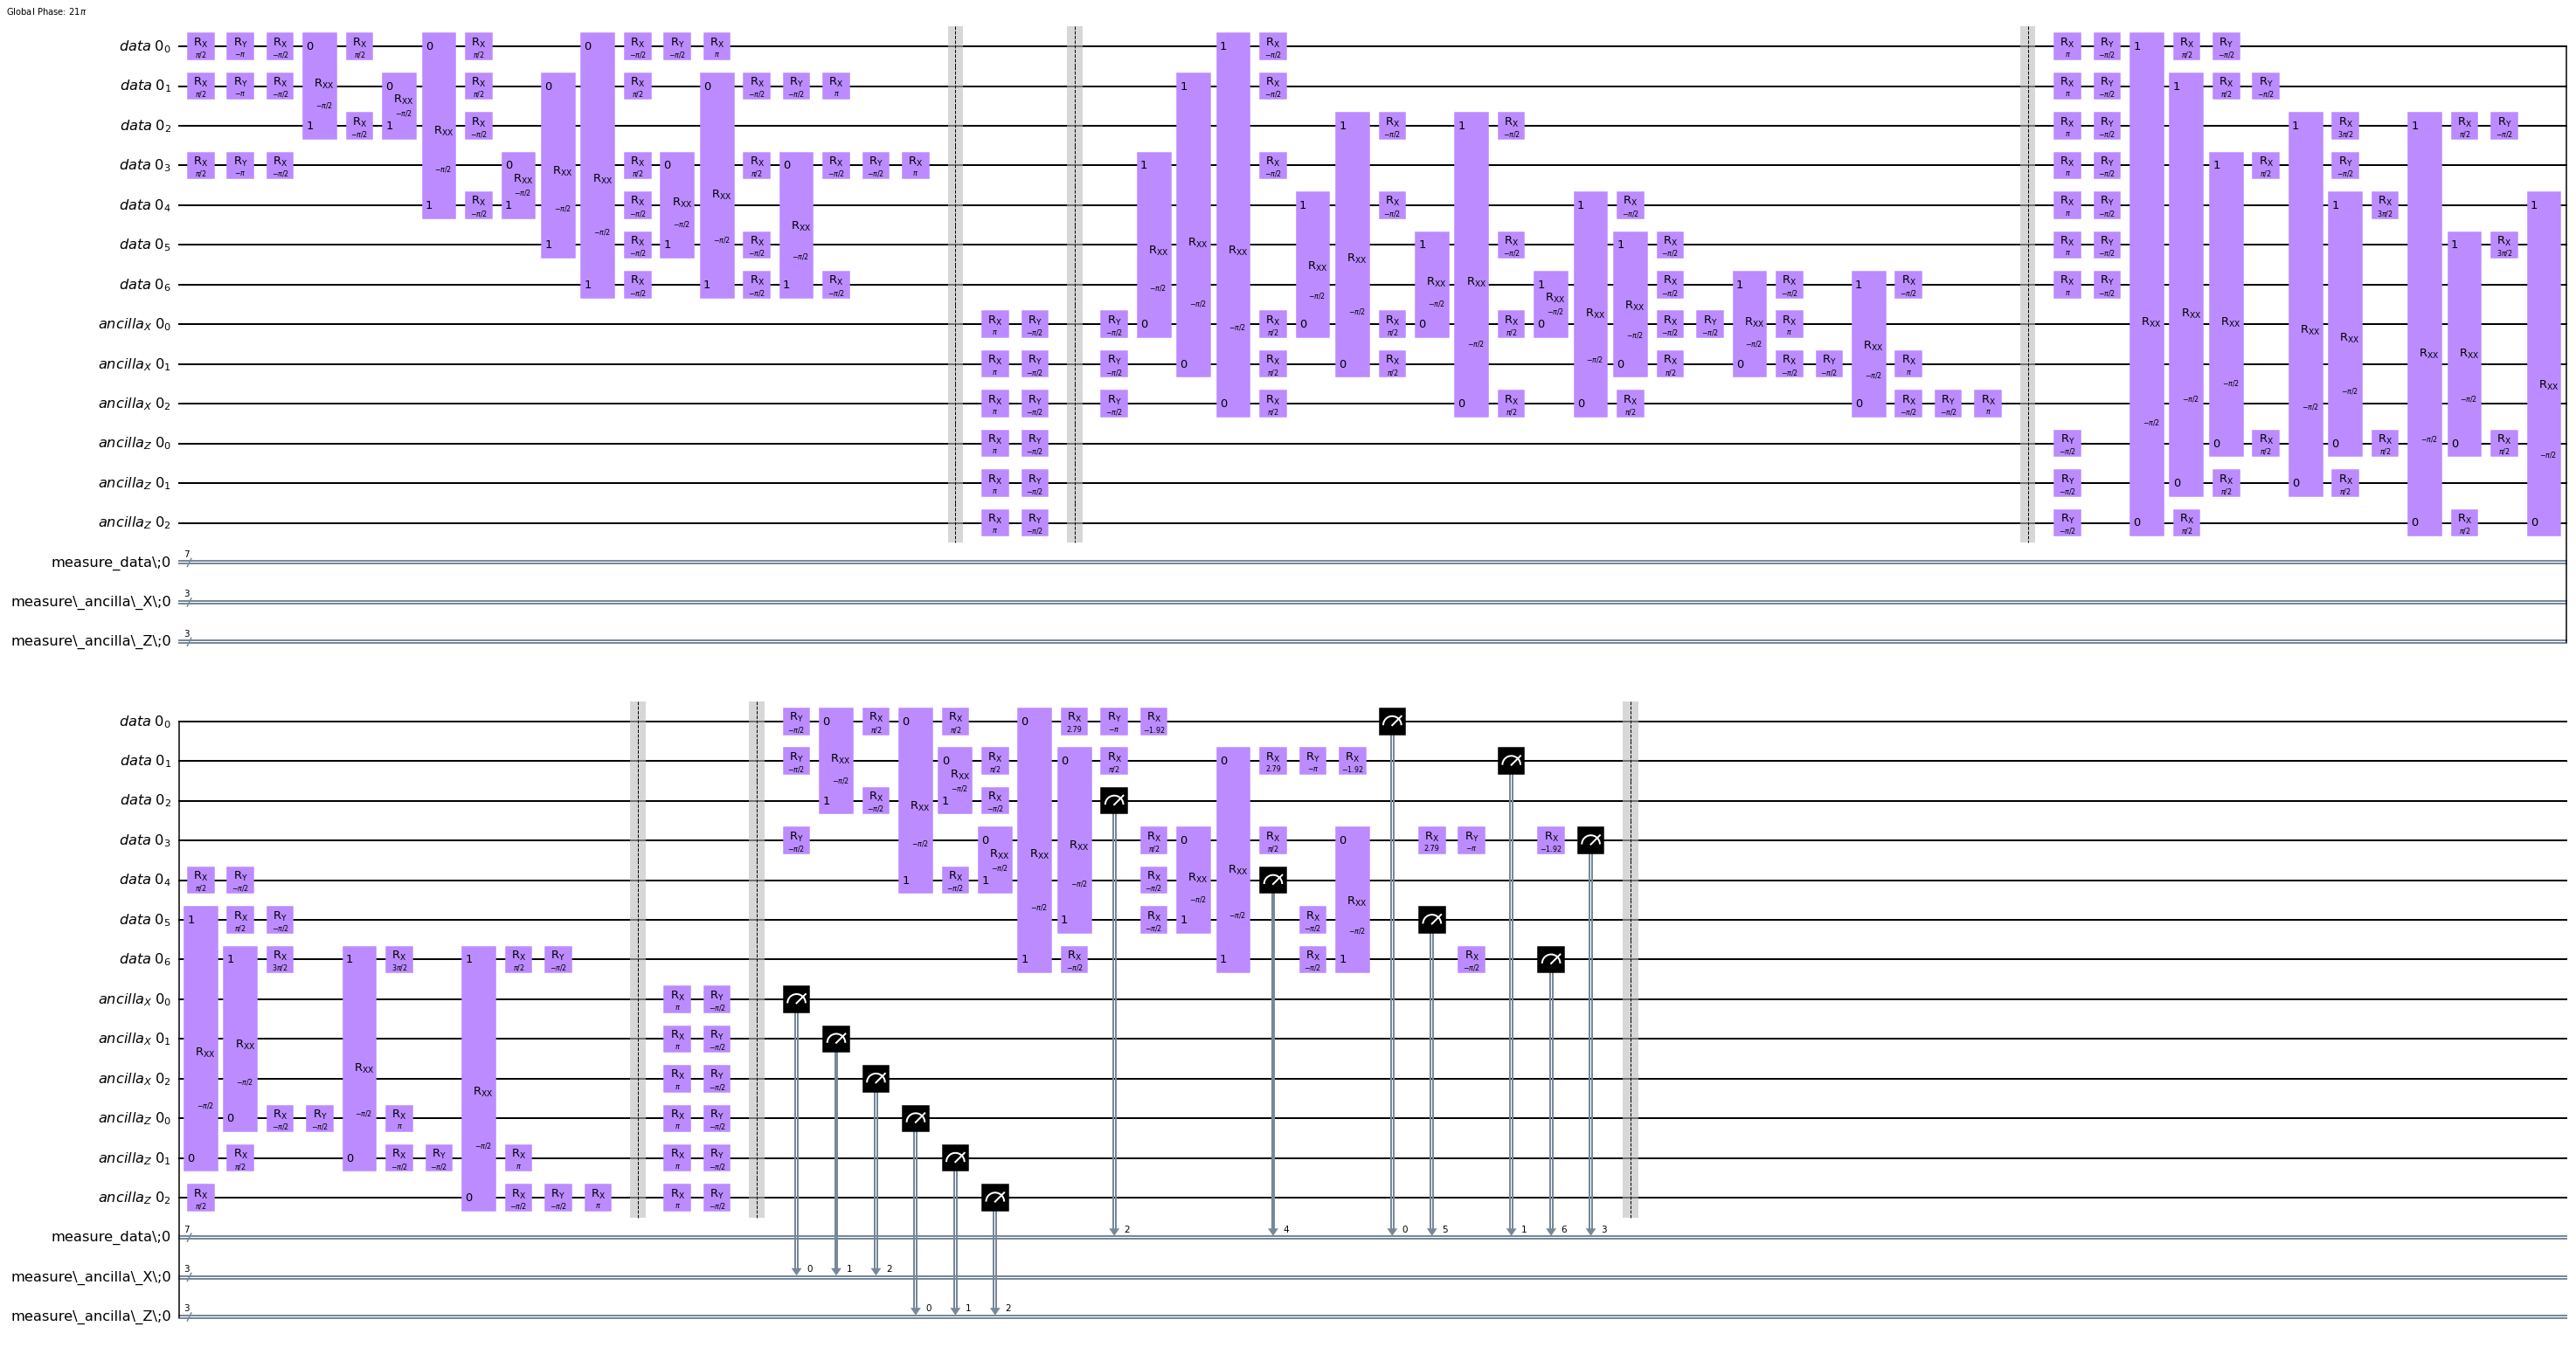

In [9]:
qt.draw(output = 'mpl', filename = 'Steane_code_error_decoding_circuit_transpiled.jpg', fold = 60)